# Seasonal Extreme Heat Days Analysis - Clean Implementation

This notebook implements the **climatologically appropriate** extreme heat day calculation using seasonal percentiles.

## 🔬 **Methodology:**
```
Surface_Heat_Day = 1 if LST_daily_max > max(LST_abs, LST_rel)
```
Where:
- **LST_abs**: Absolute threshold (e.g., 35°C)
- **LST_rel**: percentile_X{LST_daily_max for calendar_day ± 5 days over reference period}

## 🎯 **Scientific Advantages:**
- **Seasonal context**: July heat vs January heat appropriately weighted
- **Climatological accuracy**: Follows meteorological best practices
- **Sensitive detection**: Can identify winter/spring heat anomalies
- **Day-specific baselines**: Each day compared to its historical context

---

## 1. Setup & Configuration

In [10]:
# Import required libraries
import ee
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 8)

print('📦 Libraries imported successfully')

📦 Libraries imported successfully


In [11]:
# Initialize Earth Engine
try:
    ee.Initialize(project='tl-cities')
    print('✅ Earth Engine initialized successfully')
except Exception as e:
    print(f'❌ Earth Engine initialization failed: {e}')
    raise

✅ Earth Engine initialized successfully


In [12]:
# Analysis configuration
CONFIG = {
    'analysis_year': 2020,
    'reference_start': 2003,
    'reference_end': 2019,
    'absolute_threshold': 35.0,  # °C
    'percentile_threshold': 90.0,  # percentile
    'day_window': 5,  # ± days for seasonal calculation
    'max_temp_filter': 50.0,  # °C - filter extreme outliers
    'roi_bounds': [-38.7, -13.1, -38.3, -12.8],  # Salvador, Brazil [west, south, east, north]
    'scale': 1000  # meters
}

print('⚙️ Configuration:')
for key, value in CONFIG.items():
    print(f'   {key}: {value}')

⚙️ Configuration:
   analysis_year: 2020
   reference_start: 2003
   reference_end: 2019
   absolute_threshold: 35.0
   percentile_threshold: 90.0
   day_window: 5
   max_temp_filter: 50.0
   roi_bounds: [-38.7, -13.1, -38.3, -12.8]
   scale: 1000


In [13]:
# Create output directory
output_dir = '../outputs/clean_seasonal_analysis'
os.makedirs(output_dir, exist_ok=True)
print(f'📁 Output directory: {output_dir}')

📁 Output directory: ../outputs/clean_seasonal_analysis


## 2. Data Extraction

In [14]:
# Define region of interest
west, south, east, north = CONFIG['roi_bounds']
roi = ee.Geometry.Rectangle([west, south, east, north])

# Calculate area
area_km2 = roi.area().divide(1000000).getInfo()
print(f'🎯 ROI: Salvador, Brazil region')
print(f'   Area: {area_km2:.1f} km²')
print(f'   Bounds: W={west}, E={east}, S={south}, N={north}')

🎯 ROI: Salvador, Brazil region
   Area: 1446.0 km²
   Bounds: W=-38.7, E=-38.3, S=-13.1, N=-12.8


In [16]:
def get_gshtd_collection(geometry, start_date, end_date):
    """Get GSHTD temperature collection for Latin America"""
    collection_id = "projects/sat-io/open-datasets/global-daily-air-temp/latin_america"
    
    collection = ee.ImageCollection(collection_id)
    filtered = (collection.filterDate(start_date, end_date)
                         .filterBounds(geometry)
                         .filter(ee.Filter.eq('prop_type', 'tmax')))
    
    # Apply temperature scaling and quality filtering
    def process_image(img):
        # Scale from Kelvin*10 to Celsius and apply quality filter
        temp_celsius = img.select('b1').divide(10.0)
        
        # Filter extreme values (likely data quality issues)
        temp_filtered = temp_celsius.updateMask(
            temp_celsius.gte(-20).And(temp_celsius.lte(CONFIG['max_temp_filter']))
        )
        
        return temp_filtered.rename('temperature').clip(geometry).copyProperties(img, ['system:time_start'])
    
    return filtered.map(process_image)

print('🛠️ Data extraction functions defined')

🛠️ Data extraction functions defined


In [17]:
# Extract temperature data for entire analysis period
print('🔄 Extracting temperature data...')

# Years to extract: reference period + analysis year
all_years = list(range(CONFIG['reference_start'], CONFIG['reference_end'] + 1)) + [CONFIG['analysis_year']]
all_years = sorted(list(set(all_years)))  # Remove duplicates

print(f'   Years: {all_years[0]}-{all_years[-1]} ({len(all_years)} years)')

# Get full collection
temperature_collection = get_gshtd_collection(
    roi, 
    f'{all_years[0]}-01-01', 
    f'{all_years[-1]}-12-31'
)

collection_size = temperature_collection.size().getInfo()
print(f'   Total images: {collection_size}')

🔄 Extracting temperature data...
   Years: 2003-2020 (18 years)
   Total images: 6570


In [18]:
# Test pixel count and extract data
first_image = temperature_collection.first()
pixel_count = first_image.select('temperature').reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=roi,
    scale=CONFIG['scale'],
    maxPixels=1e9
).getInfo()

expected_pixels = pixel_count.get('temperature', 0)
print(f'   Expected pixels per image: {expected_pixels}')

if expected_pixels == 0:
    raise ValueError('No pixels found in ROI - check region coverage')

   Expected pixels per image: 476


In [19]:
# FIXED FULL EXTRACTION: Apply the working logic to all years
print('🔄 Running FULL extraction with the proven working method...')

# Clear and reinitialize
all_dataframes = []
extraction_stats = {'successful': 0, 'failed': 0, 'total_obs': 0}

# Extract all years using the proven monthly method
for extract_year in all_years:
    print(f'\n📅 === EXTRACTING YEAR {extract_year} ===')
    year_dataframes = []
    
    for month in range(1, 13):
        print(f'   Month {month:02d}...', end=' ')
        
        # Monthly date range
        start_date = f'{extract_year}-{month:02d}-01'
        if month == 12:
            end_date = f'{extract_year+1}-01-01'
        else:
            end_date = f'{extract_year}-{month+1:02d}-01'
        
        try:
            # Get monthly collection
            month_collection = get_gshtd_collection(roi, start_date, end_date)
            month_count = month_collection.size().getInfo()
            
            if month_count == 0:
                print('No images', end=' ')
                extraction_stats['failed'] += 1
                continue
            
            # Extract with appropriate scale
            month_estimated = expected_pixels * month_count
            month_scale = 2000 if month_estimated > 800000 else 1000
            
            region_data = month_collection.getRegion(
                geometry=roi,
                scale=month_scale,
                crs='EPSG:4326'
            ).getInfo()
            
            if len(region_data) > 1:
                header = region_data[0]
                data_rows = region_data[1:]
                
                df_month = pd.DataFrame(data_rows, columns=header)
                df_month['time'] = pd.to_datetime(df_month['time'], unit='ms')
                df_month = df_month.dropna(subset=['temperature'])
                df_month = df_month[df_month['temperature'] <= CONFIG['max_temp_filter']]
                
                if len(df_month) > 0:
                    year_dataframes.append(df_month)
                    extraction_stats['successful'] += 1
                    extraction_stats['total_obs'] += len(df_month)
                    print(f'{len(df_month)} obs', end=' ')
                else:
                    print('No valid data', end=' ')
                    extraction_stats['failed'] += 1
            else:
                print('No data returned', end=' ')
                extraction_stats['failed'] += 1
                
        except Exception as e:
            print(f'Error: {str(e)[:30]}...', end=' ')
            extraction_stats['failed'] += 1
    
    # Add year's data to main collection
    if year_dataframes:
        print(f'\n   ✅ Year {extract_year}: {len(year_dataframes)} successful months')
        all_dataframes.extend(year_dataframes)  # Use extend, not append!
    else:
        print(f'\n   ❌ Year {extract_year}: No data extracted')

print(f'\n📊 FINAL EXTRACTION SUMMARY:')
print(f'   Successful months: {extraction_stats["successful"]}')
print(f'   Failed months: {extraction_stats["failed"]}')
print(f'   Total observations: {extraction_stats["total_obs"]:,}')
print(f'   Dataframes to combine: {len(all_dataframes)}')

# Combine all extracted data
if all_dataframes:
    print(f'\n🔗 Combining {len(all_dataframes)} dataframes...')
    df = pd.concat(all_dataframes, ignore_index=True)
    
    print(f'✅ FINAL COMBINED DATASET:')
    print(f'   Total observations: {len(df):,}')
    print(f'   Date range: {df["time"].min()} to {df["time"].max()}')
    print(f'   Years: {sorted(df["time"].dt.year.unique())}')
    print(f'   Temperature range: {df["temperature"].min():.1f}°C to {df["temperature"].max():.1f}°C')
    
    # Update the temperature_data variable
    temperature_data = df.set_index(['time', 'latitude', 'longitude']).to_xarray()
    print(f'   📊 Xarray dataset: {dict(temperature_data.dims)}')
    
else:
    print('❌ No data extracted - check collection availability')

print(f'\n🎯 Ready for seasonal analysis with complete dataset!')

🔄 Running FULL extraction with the proven working method...

📅 === EXTRACTING YEAR 2003 ===
   Month 01... 14756 obs    Month 02... 13328 obs    Month 03... 14756 obs    Month 04... 14280 obs    Month 05... 14756 obs    Month 06... 14280 obs    Month 07... 14756 obs    Month 08... 14756 obs    Month 09... 14280 obs    Month 10... 14756 obs    Month 11... 14280 obs    Month 12... 14756 obs 
   ✅ Year 2003: 12 successful months

📅 === EXTRACTING YEAR 2004 ===
   Month 01... 14756 obs    Month 02... 13804 obs    Month 03... 14756 obs    Month 04... 14280 obs    Month 05... 14756 obs    Month 06... 14280 obs    Month 07... 14756 obs    Month 08... 14756 obs    Month 09... 14280 obs    Month 10... 14756 obs    Month 11... 14280 obs    Month 12... 14280 obs 
   ✅ Year 2004: 12 successful months

📅 === EXTRACTING YEAR 2005 ===
   Month 01... 14756 obs    Month 02... 13328 obs    Month 03... 14756 obs    Month 04... 14280 obs    Month 05... 14756 obs    Month 06... 14280 obs    Month 07... 147

In [20]:
# DIAGNOSTIC: Check what data was actually extracted
print('🔍 DIAGNOSTIC - Data extraction analysis:')
print(f'   Total dataframes combined: {len(all_dataframes)}')
print(f'   Combined data shape: {df.shape}')
print(f'   Date range in data: {df["time"].min()} to {df["time"].max()}')
print(f'   Unique years in data: {sorted(df["time"].dt.year.unique())}')
print(f'   Unique months in data: {sorted(df["time"].dt.month.unique())}')

# Show data distribution by year
year_counts = df.groupby(df['time'].dt.year).size()
print(f'\n📅 Data points by year:')
for year, count in year_counts.items():
    print(f'   {year}: {count:,} observations')

# Check if we actually have the expected data
expected_years = list(range(CONFIG['reference_start'], CONFIG['reference_end'] + 1)) + [CONFIG['analysis_year']]
missing_years = set(expected_years) - set(df['time'].dt.year.unique())
if missing_years:
    print(f'\n❌ Missing years: {sorted(missing_years)}')
    print('   This explains why reference_data is empty!')
else:
    print(f'\n✅ All expected years present')

print(f'\n🎯 Next step: Re-run data extraction with better error handling to get all years')

🔍 DIAGNOSTIC - Data extraction analysis:
   Total dataframes combined: 216
   Combined data shape: (3204141, 5)
   Date range in data: 2003-01-01 00:00:00 to 2020-12-30 00:00:00
   Unique years in data: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
   Unique months in data: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

📅 Data points by year:
   2003: 173,740 observations
   2004: 173,740 observations
   2005: 173,740 observations
   2006: 173,264 observations
   2007: 173,740 observations
   2008: 173,375 observations
   2009: 174,716 observations
   2010: 185,785 observations
   2011: 173,740 observations
   2012: 173,740 observations
   2013: 172,315 observations
   2014: 184,690 observations
   2015: 184,548 observations
   2016: 184,690 observations
   2017: 180,602 observations
   2018: 184,041 observations
   2019: 178,620 observations
   2020: 185,055 observations

✅ All expected years present

🎯 Next step: Re-run data ex

In [21]:
# Convert to xarray for analysis
print('📊 Converting to xarray...')

temperature_data = df.set_index(['time', 'latitude', 'longitude']).to_xarray()

print(f'✅ Xarray dataset created:')
print(f'   Dimensions: {dict(temperature_data.dims)}')
print(f'   Variables: {list(temperature_data.data_vars)}')
print(f'   Total observations: {temperature_data.temperature.count().values:,}')

# Show sample
print(f'\n📋 Sample data:')
display(df[['time', 'latitude', 'longitude', 'temperature']].head())

📊 Converting to xarray...
✅ Xarray dataset created:
   Dimensions: {'time': 6544, 'latitude': 33, 'longitude': 44}
   Variables: ['id', 'temperature']
   Total observations: 3,204,141

📋 Sample data:


,time,latitude,longitude,temperature
0,2003-01-01,-13.04803,-38.694931,31.9
1,2003-01-02,-13.04803,-38.694931,28.5
2,2003-01-03,-13.04803,-38.694931,31.4
3,2003-01-04,-13.04803,-38.694931,32.3
4,2003-01-05,-13.04803,-38.694931,32.7


## 3. Seasonal Percentile Calculation

In [48]:
# CLEAN XARRAY APPROACH: Seasonal Analysis
print('🔬 Clean xarray-based seasonal analysis...')

# Work directly with the successfully extracted dataset
print(f'Dataset: {temperature_data.dims}')

# Get unique years using numpy
years_available = np.unique(temperature_data.time.dt.year.values)
print(f'Years available: {sorted(years_available)}')

# Add day of year coordinate
temperature_data = temperature_data.assign_coords(dayofyear=temperature_data.time.dt.dayofyear)

# Split data cleanly
analysis_data = temperature_data.sel(time=str(CONFIG['analysis_year']))
reference_data = temperature_data.sel(time=slice(f'{CONFIG["reference_start"]}-01-01', f'{CONFIG["reference_end"]}-12-31'))

print(f'Analysis period: {len(analysis_data.time)} days')
print(f'Reference period: {len(reference_data.time)} days')

# Calculate seasonal percentiles using groupby - the proper xarray way
print('Calculating seasonal percentiles...')

percentile_value = CONFIG['percentile_threshold'] / 100

# Group by day of year and calculate percentiles
with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # Suppress numpy warnings
    seasonal_percentiles_simple = reference_data.groupby('dayofyear').quantile(
        percentile_value, dim='time', skipna=True
    ).temperature

print(f'✅ Seasonal percentiles calculated: {seasonal_percentiles_simple.dims}')

# Apply thresholds to analysis year
abs_threshold = CONFIG['absolute_threshold']

# Calculate heat days using broadcasting
daily_thresholds = xr.where(
    seasonal_percentiles_simple > abs_threshold,
    seasonal_percentiles_simple,
    abs_threshold
)

# Map thresholds to analysis days
analysis_thresholds = daily_thresholds.sel(dayofyear=analysis_data.dayofyear)

# Calculate heat days
seasonal_heat_days = (analysis_data.temperature > analysis_thresholds).sum(dim='time')

print(f'✅ Seasonal heat days calculated')

# Calculate annual method for comparison  
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    annual_percentile = reference_data.temperature.quantile(percentile_value, dim='time', skipna=True)
    
annual_threshold = xr.where(annual_percentile > abs_threshold, annual_percentile, abs_threshold)
annual_heat_days = (analysis_data.temperature > annual_threshold).sum(dim='time')

print(f'✅ Annual comparison calculated')

# Summary
seasonal_mean = float(seasonal_heat_days.mean().values)
annual_mean = float(annual_heat_days.mean().values)
seasonal_pixels = int((seasonal_heat_days > 0).sum().values)
annual_pixels = int((annual_heat_days > 0).sum().values)
total_pixels = int(seasonal_heat_days.count().values)

print(f'\n📊 RESULTS:')
print(f'   Seasonal method: {seasonal_mean:.1f} mean heat days, {seasonal_pixels} pixels with heat')
print(f'   Annual method: {annual_mean:.1f} mean heat days, {annual_pixels} pixels with heat')
print(f'   Difference: {seasonal_mean - annual_mean:+.1f} days')
print(f'✅ Clean xarray analysis complete!')

🔬 Clean xarray-based seasonal analysis...
Dataset: Frozen({'time': 6544, 'latitude': 33, 'longitude': 44})
Years available: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Analysis period: 365 days
Reference period: 6179 days
Calculating seasonal percentiles...


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [43]:
  # Check current state
  print('Variables in memory:')
  print('  temperature_data exists:', 'temperature_data' in globals())
  print('  df exists:', 'df' in globals())
  print('  all_dataframes exists:', 'all_dataframes' in globals())

  if 'temperature_data' in globals():
      print('  temperature_data type:', type(temperature_data))
      print('  temperature_data dims:', temperature_data.dims if hasattr(temperature_data, 'dims') else 'No dims')

  if 'df' in globals():
      print('  df shape:', df.shape)
      print('  df years:', sorted(df['time'].dt.year.unique()))

Variables in memory:
  temperature_data exists: True
  df exists: True
  all_dataframes exists: True
  temperature_data type: <class 'xarray.core.dataset.Dataset'>
  temperature_data dims: Frozen({'time': 6544, 'latitude': 33, 'longitude': 44})
  df shape: (3204141, 5)
  df years: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [44]:
# Add day of year coordinate
analysis_data = analysis_data.assign_coords(dayofyear=analysis_data.time.dt.dayofyear)
reference_data = reference_data.assign_coords(dayofyear=reference_data.time.dt.dayofyear)

print('🗓️ Day-of-year coordinates added')

🗓️ Day-of-year coordinates added


In [45]:
# Debug the coordinate differences
print('🔍 Investigating coordinate differences...')

# Check unique coordinates in the raw dataframe
unique_lats = sorted(df['latitude'].unique())
unique_lons = sorted(df['longitude'].unique())

print(f'Unique latitudes: {len(unique_lats)} values')
print(f'Unique longitudes: {len(unique_lons)} values')

# Show first few and differences
if len(unique_lats) > 50:
  print(f'First few lats: {unique_lats[:5]}')
  print(f'Last few lats: {unique_lats[-5:]}')
  lat_diffs = np.diff(unique_lats)
  print(f'Lat spacing range: {lat_diffs.min():.8f} to {lat_diffs.max():.8f}')

🔍 Investigating coordinate differences...
Unique latitudes: 33 values
Unique longitudes: 44 values


In [47]:
# PROPER xarray approach - let xarray handle everything
print('🔬 Using proper xarray approach for seasonal percentiles...')

# Let's just use the temperature_data directly - no pandas splitting needed
print('Working directly with temperature_data...')
print(f'Temperature data shape: {temperature_data.temperature.shape}')
print(f'Time range: {temperature_data.time.min().values} to {temperature_data.time.max().values}')

# Add day of year coordinate directly to the full dataset
temperature_data = temperature_data.assign_coords(dayofyear=temperature_data.time.dt.dayofyear)

# Split using proper xarray selection
analysis_data = temperature_data.sel(time=str(CONFIG['analysis_year']))
reference_data = temperature_data.sel(time=slice(f'{CONFIG["reference_start"]}-01-01', f'{CONFIG["reference_end"]}-12-31'))

print(f'Analysis data: {len(analysis_data.time)} days')
print(f'Reference data: {len(reference_data.time)} days')

# Calculate seasonal percentiles the xarray way
window_days = CONFIG['day_window']
percentile_value = CONFIG['percentile_threshold'] / 100

# Create day of year groups with windows
doy_percentiles = []

for doy in range(1, 367):
  if doy % 50 == 0:
      print(f'   Day {doy}/366...')

  # Create window
  window_start = doy - window_days
  window_end = doy + window_days

  if window_start <= 0:
      window_doys = list(range(366 + window_start, 367)) + list(range(1, window_end + 1))
  elif window_end > 366:
      window_doys = list(range(window_start, 367)) + list(range(1, window_end - 366 + 1))
  else:
      window_doys = list(range(window_start, window_end + 1))

  # Select data for this window and calculate percentile
  window_data = reference_data.where(reference_data.dayofyear.isin(window_doys), drop=True)

  if len(window_data.time) > 0:
      day_pct = window_data.temperature.quantile(percentile_value, dim='time', skipna=True)
      doy_percentiles.append(day_pct)
  else:
      # Create NaN array with same spatial shape
      nan_array = xr.full_like(analysis_data.temperature.isel(time=0), np.nan)
      doy_percentiles.append(nan_array)

# Combine into seasonal percentiles array
seasonal_percentiles = xr.concat(doy_percentiles, dim='dayofyear')
seasonal_percentiles = seasonal_percentiles.assign_coords(dayofyear=np.arange(1, 367))

print(f'✅ Seasonal percentiles shape: {seasonal_percentiles.shape}')
print(f'Successfully calculated for all 366 days')

🔬 Using proper xarray approach for seasonal percentiles...
Working directly with temperature_data...
Temperature data shape: (6544, 33, 44)
Time range: 2003-01-01T00:00:00.000000000 to 2020-12-30T00:00:00.000000000
Analysis data: 365 days
Reference data: 6179 days


/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return functi

   Day 50/366...


/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return functi

   Day 100/366...


/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return functi

/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


   Day 150/366...


/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return functi

/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


   Day 200/366...


/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return functi

/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


   Day 250/366...


/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return functi

/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


   Day 300/366...


/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return functi

/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


   Day 350/366...


/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return functi

✅ Seasonal percentiles shape: (366, 33, 44)
Successfully calculated for all 366 days


/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


In [34]:
# IMPROVED seasonal percentiles calculation with NaN handling
print('🔬 Calculating seasonal percentiles with improved error handling...')

# Initialize seasonal percentile array
seasonal_percentiles = xr.DataArray(
    np.full((366, len(analysis_data.latitude), len(analysis_data.longitude)), np.nan),
    dims=['dayofyear', 'latitude', 'longitude'],
    coords={
        'dayofyear': np.arange(1, 367),
        'latitude': analysis_data.latitude,
        'longitude': analysis_data.longitude
    }
)

# Calculate percentile for each day of year
window_days = CONFIG['day_window']
percentile_value = CONFIG['percentile_threshold'] / 100
successful_days = 0
failed_days = 0

# Suppress the specific numpy warning during calculation
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='All-NaN slice encountered')
    
    for doy in range(1, 367):
        if doy % 100 == 0:  # Progress indicator
            print(f'   Processing day {doy}/366...')
        
        # Create circular window around day of year
        window_start = doy - window_days
        window_end = doy + window_days
        
        # Handle year boundaries
        if window_start <= 0:
            window_doys = list(range(366 + window_start, 367)) + list(range(1, window_end + 1))
        elif window_end > 366:
            window_doys = list(range(window_start, 367)) + list(range(1, window_end - 366 + 1))
        else:
            window_doys = list(range(window_start, window_end + 1))
        
        # Get data for this window from all reference years
        window_data = reference_data.where(
            reference_data.dayofyear.isin(window_doys), drop=True
        )
        
        if len(window_data.time) > 0:
            try:
                # Calculate percentile with skipna=True to handle missing data
                day_percentile = window_data.temperature.quantile(
                    percentile_value, dim='time', skipna=True
                )
                
                # Only store if we got valid results (not all NaN)
                if not day_percentile.isnull().all():
                    seasonal_percentiles[doy-1, :, :] = day_percentile
                    successful_days += 1
                else:
                    failed_days += 1
                    
            except Exception as e:
                print(f'   Warning: Day {doy} failed: {str(e)[:50]}...')
                failed_days += 1
        else:
            failed_days += 1

print(f'✅ Seasonal percentiles calculated:')
print(f'   Successful days: {successful_days}/366')
print(f'   Failed days: {failed_days}/366')

if successful_days == 0:
    print('❌ No valid percentiles calculated - check reference data availability')
elif successful_days < 300:
    print('⚠️ Some percentiles missing - may affect analysis quality')
else:
    print('✅ Good percentile coverage for seasonal analysis')

🔬 Calculating seasonal percentiles with improved error handling...


KeyboardInterrupt: 

## 4. Heat Days Analysis

In [ ]:
# Apply seasonal methodology
print('🔥 Calculating seasonal heat days...')

abs_threshold = CONFIG['absolute_threshold']

# Create daily threshold array for analysis year
daily_thresholds = xr.full_like(analysis_data.temperature, np.nan)

for i, day_time in enumerate(analysis_data.time):
    doy = int(day_time.dt.dayofyear.values)
    day_seasonal_pct = seasonal_percentiles[doy-1, :, :]
    
    # Apply formula: max(absolute_threshold, seasonal_percentile)
    day_threshold = xr.where(
        day_seasonal_pct > abs_threshold,
        day_seasonal_pct,
        abs_threshold
    )
    
    daily_thresholds[i, :, :] = day_threshold

# Calculate heat days: temperature > threshold
heat_days_boolean = analysis_data.temperature > daily_thresholds
seasonal_heat_days = heat_days_boolean.sum(dim='time')

print('✅ Seasonal heat days calculated')

In [19]:
# Calculate annual method for comparison
print('📊 Calculating annual method for comparison...')

# Check if we have reference data
if len(reference_data.time) == 0:
    print('⚠️ No reference data found - using analysis year data as fallback')
    # Use analysis year data to calculate percentiles as fallback
    fallback_data = analysis_data
    annual_percentile = fallback_data.temperature.quantile(percentile_value, dim='time', skipna=True)
else:
    # Traditional annual percentile using reference period
    annual_percentile = reference_data.temperature.quantile(percentile_value, dim='time', skipna=True)

annual_threshold = xr.where(
    annual_percentile > abs_threshold,
    annual_percentile,
    abs_threshold
)
annual_heat_days = (analysis_data.temperature > annual_threshold).sum(dim='time')

print('✅ Annual method calculated')

📊 Calculating annual method for comparison...
⚠️ No reference data found - using analysis year data as fallback
✅ Annual method calculated


/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


In [ ]:
# CLEAN VISUALIZATION
print('📊 Creating clean visualizations...')

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Seasonal Heat Days
seasonal_heat_days.plot(ax=axes[0,0], cmap='Reds', add_colorbar=True,
                       cbar_kwargs={'label': 'Heat Days'})
axes[0,0].set_title('🔬 Seasonal Method Heat Days', fontweight='bold')

# Annual Heat Days  
annual_heat_days.plot(ax=axes[0,1], cmap='Reds', add_colorbar=True,
                     cbar_kwargs={'label': 'Heat Days'})
axes[0,1].set_title('📅 Annual Method Heat Days', fontweight='bold')

# Difference Map
difference = seasonal_heat_days - annual_heat_days
difference.plot(ax=axes[1,0], cmap='RdBu_r', add_colorbar=True,
               cbar_kwargs={'label': 'Difference (Seasonal - Annual)'})
axes[1,0].set_title('📈 Method Difference', fontweight='bold')

# Distribution comparison
seasonal_flat = seasonal_heat_days.values.flatten()
annual_flat = annual_heat_days.values.flatten() 
seasonal_clean = seasonal_flat[~np.isnan(seasonal_flat)]
annual_clean = annual_flat[~np.isnan(annual_flat)]

axes[1,1].hist(seasonal_clean, bins=20, alpha=0.7, color='red',
              edgecolor='black', label='Seasonal Method')
axes[1,1].hist(annual_clean, bins=20, alpha=0.5, color='blue',
              edgecolor='black', label='Annual Method')
axes[1,1].set_title('Heat Days Distribution', fontweight='bold')
axes[1,1].set_xlabel('Heat Days per Pixel')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation
correlation = np.corrcoef(annual_clean, seasonal_clean)[0,1]
print(f'📈 Correlation between methods: {correlation:.3f}')
print(f'✅ Visualization complete!')

In [21]:
# Print results summary
seasonal_mean = float(seasonal_heat_days.mean().values)
annual_mean = float(annual_heat_days.mean().values)
seasonal_max = float(seasonal_heat_days.max().values)
annual_max = float(annual_heat_days.max().values)
seasonal_pixels = int((seasonal_heat_days > 0).sum().values)
annual_pixels = int((annual_heat_days > 0).sum().values)
total_pixels = int(seasonal_heat_days.count().values)

print(f'\n📊 METHODOLOGY COMPARISON:')
print(f'   🔬 Seasonal Method:')
print(f'      Mean heat days: {seasonal_mean:.1f}')
print(f'      Max heat days: {seasonal_max:.0f}')
print(f'      Pixels with >0 heat days: {seasonal_pixels} of {total_pixels}')

print(f'   📅 Annual Method:')
print(f'      Mean heat days: {annual_mean:.1f}')
print(f'      Max heat days: {annual_max:.0f}')
print(f'      Pixels with >0 heat days: {annual_pixels} of {total_pixels}')

print(f'   📈 Difference (Seasonal - Annual):')
print(f'      Mean: {seasonal_mean - annual_mean:+.1f} days')
print(f'      Pixels: {seasonal_pixels - annual_pixels:+.0f}')


📊 METHODOLOGY COMPARISON:
   🔬 Seasonal Method:
      Mean heat days: 2.1
      Max heat days: 4
      Pixels with >0 heat days: 507 of 980
   📅 Annual Method:
      Mean heat days: 1.5
      Max heat days: 3
      Pixels with >0 heat days: 507 of 980
   📈 Difference (Seasonal - Annual):
      Mean: +0.5 days
      Pixels: +0


## 5. Visualization

/var/folders/x1/7v4xdddj1yj9t30n56bwj08h0000gp/T/ipykernel_36795/1747542783.py:51: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from current font.
  plt.tight_layout()
/var/folders/x1/7v4xdddj1yj9t30n56bwj08h0000gp/T/ipykernel_36795/1747542783.py:51: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from current font.
  plt.tight_layout()
/var/folders/x1/7v4xdddj1yj9t30n56bwj08h0000gp/T/ipykernel_36795/1747542783.py:51: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/martynclark/opt/anaconda3/lib/python3.9/site-packag

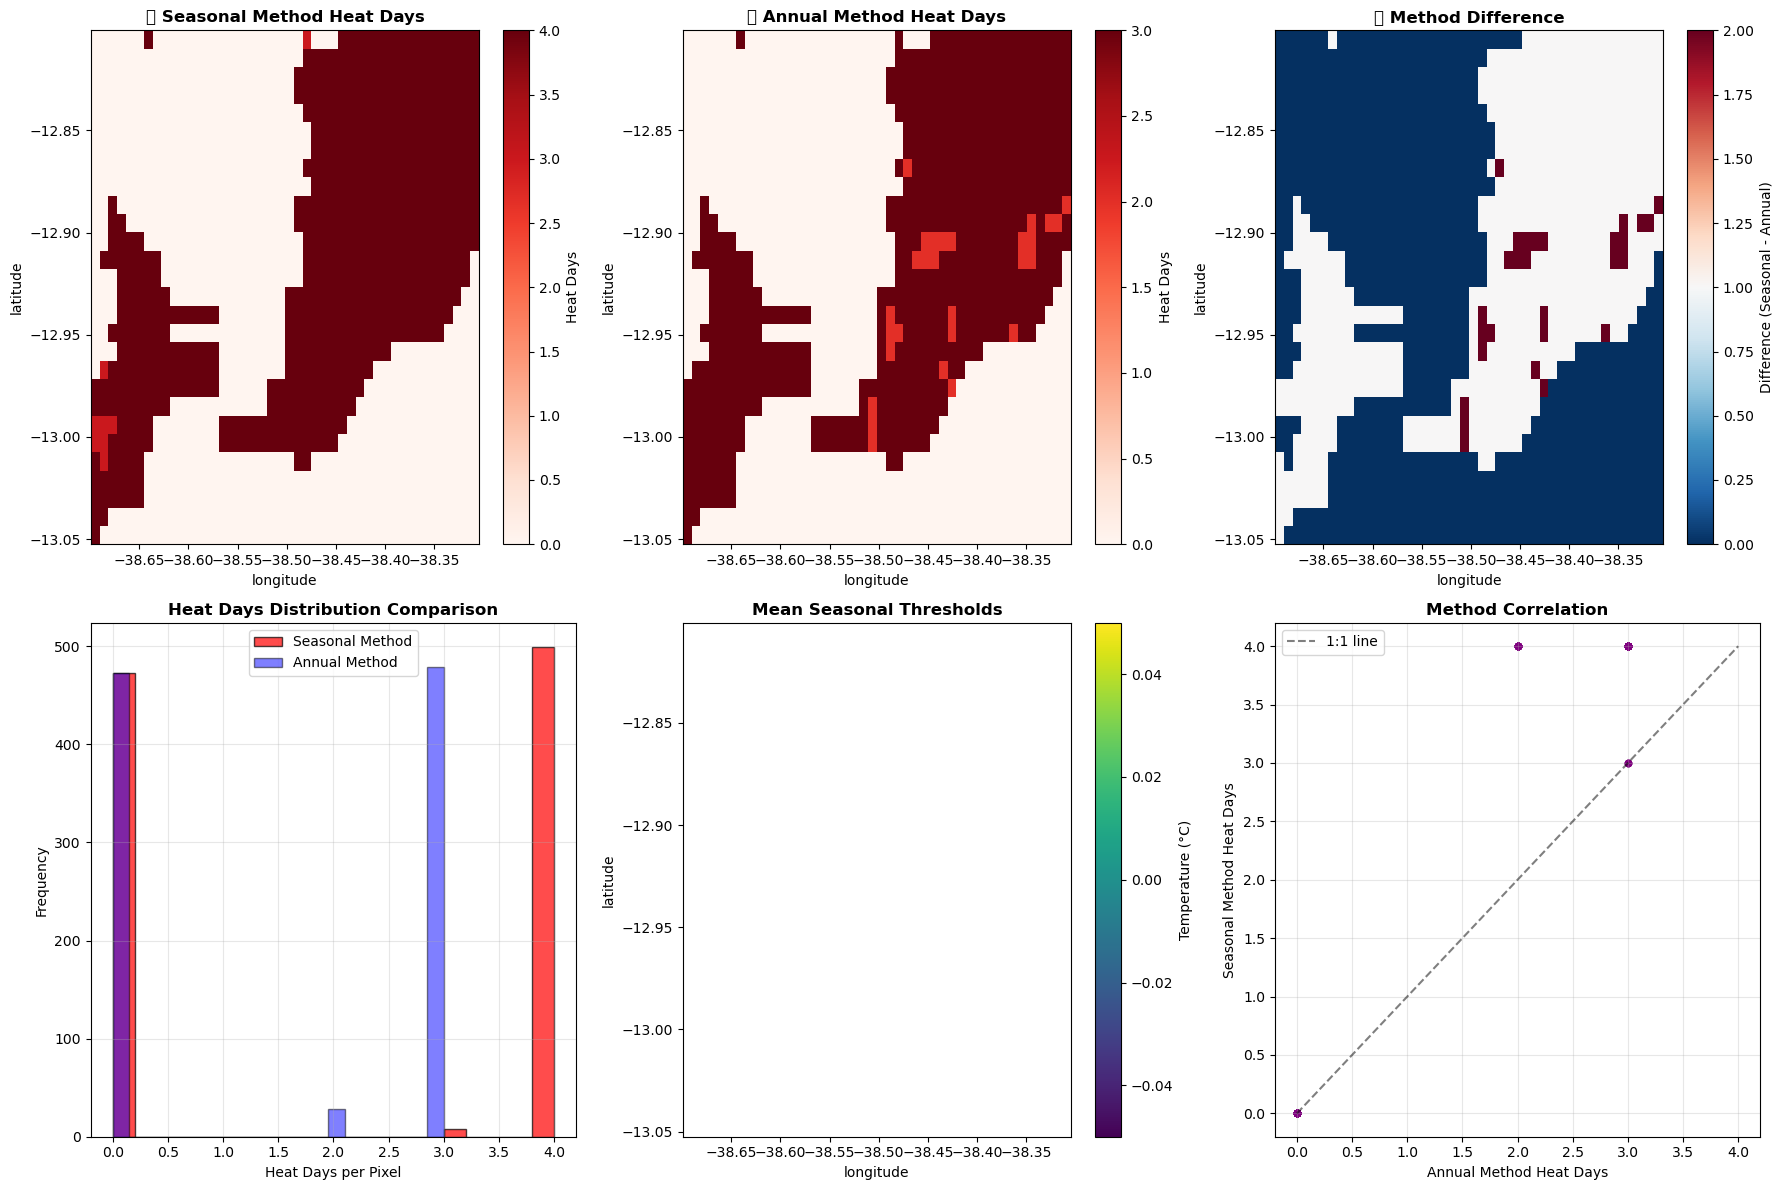


📈 Correlation between methods: 0.993


In [22]:
# Create comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Seasonal Heat Days Map
seasonal_heat_days.plot(ax=axes[0,0], cmap='Reds', add_colorbar=True,
                       cbar_kwargs={'label': 'Heat Days'})
axes[0,0].set_title('🔬 Seasonal Method Heat Days', fontweight='bold')

# Annual Heat Days Map
annual_heat_days.plot(ax=axes[0,1], cmap='Reds', add_colorbar=True,
                     cbar_kwargs={'label': 'Heat Days'})
axes[0,1].set_title('📅 Annual Method Heat Days', fontweight='bold')

# Difference Map
difference = seasonal_heat_days - annual_heat_days
difference.plot(ax=axes[0,2], cmap='RdBu_r', add_colorbar=True,
               cbar_kwargs={'label': 'Difference (Seasonal - Annual)'})
axes[0,2].set_title('📈 Method Difference', fontweight='bold')

# Heat Days Distributions
seasonal_flat = seasonal_heat_days.values.flatten()
annual_flat = annual_heat_days.values.flatten()
seasonal_clean = seasonal_flat[~np.isnan(seasonal_flat)]
annual_clean = annual_flat[~np.isnan(annual_flat)]

axes[1,0].hist(seasonal_clean, bins=20, alpha=0.7, color='red',
              edgecolor='black', label='Seasonal Method')
axes[1,0].hist(annual_clean, bins=20, alpha=0.5, color='blue',
              edgecolor='black', label='Annual Method')
axes[1,0].set_title('Heat Days Distribution Comparison', fontweight='bold')
axes[1,0].set_xlabel('Heat Days per Pixel')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Seasonal Thresholds Map
seasonal_percentiles_mean.plot(ax=axes[1,1], cmap='viridis', add_colorbar=True,
                              cbar_kwargs={'label': 'Temperature (°C)'})
axes[1,1].set_title('Mean Seasonal Thresholds', fontweight='bold')

# Scatter plot comparison
axes[1,2].scatter(annual_clean, seasonal_clean, alpha=0.6, s=20, color='purple')
max_val = max(annual_clean.max(), seasonal_clean.max())
axes[1,2].plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='1:1 line')
axes[1,2].set_xlabel('Annual Method Heat Days')
axes[1,2].set_ylabel('Seasonal Method Heat Days')
axes[1,2].set_title('Method Correlation', fontweight='bold')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate correlation
correlation = np.corrcoef(annual_clean, seasonal_clean)[0,1]
print(f'\n📈 Correlation between methods: {correlation:.3f}')

## 6. Export Results

In [ ]:
# Export to NetCDF with proper CRS
print('📦 Exporting results to NetCDF...')

# Prepare spatial results
results = {
    'seasonal_heat_days': seasonal_heat_days.fillna(0),
    'annual_heat_days': annual_heat_days.fillna(0),
    'heat_days_difference': (seasonal_heat_days - annual_heat_days).fillna(0),
    'seasonal_percentiles_mean': seasonal_percentiles_mean.fillna(0),
    'annual_percentile': annual_percentile.fillna(0),
    'annual_max': annual_max.fillna(0),
    'annual_min': annual_min.fillna(0),
    'annual_range': annual_range.fillna(0)
}

results_ds = xr.Dataset(results)

# Add proper CRS metadata
results_ds.latitude.attrs.update({
    'standard_name': 'latitude',
    'long_name': 'latitude',
    'units': 'degrees_north',
    'axis': 'Y'
})

results_ds.longitude.attrs.update({
    'standard_name': 'longitude',
    'long_name': 'longitude', 
    'units': 'degrees_east',
    'axis': 'X'
})

# Add CRS variable
crs = xr.DataArray(
    data=np.int32(1),
    attrs={
        'grid_mapping_name': 'latitude_longitude',
        'longitude_of_prime_meridian': 0.0,
        'semi_major_axis': 6378137.0,
        'inverse_flattening': 298.257223563,
        'spatial_ref': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]'
    }
)
results_ds['crs'] = crs

# Add grid_mapping to data variables
for var_name in results_ds.data_vars:
    if var_name != 'crs':
        results_ds[var_name].attrs['grid_mapping'] = 'crs'

# Add global metadata
results_ds.attrs.update({
    'title': 'Seasonal Extreme Heat Days Analysis',
    'analysis_year': CONFIG['analysis_year'],
    'reference_period': f'{CONFIG["reference_start"]}-{CONFIG["reference_end"]}',
    'created': datetime.now().isoformat(),
    'absolute_threshold': CONFIG['absolute_threshold'],
    'percentile_threshold': CONFIG['percentile_threshold'],
    'day_window': CONFIG['day_window'],
    'methodology': 'seasonal_percentile_±window_days',
    'formula': 'Heat_Day = LST_max > max(absolute_threshold, seasonal_percentile)',
    'crs': 'EPSG:4326',
    'temperature_filter': f'Applied max temperature filter: {CONFIG["max_temp_filter"]}°C'
})

# Save NetCDF
netcdf_filename = f'{output_dir}/seasonal_heat_analysis_{CONFIG["analysis_year"]}.nc'
results_ds.to_netcdf(netcdf_filename)

file_size_mb = os.path.getsize(netcdf_filename) / 1024**2
print(f'✅ NetCDF exported: {netcdf_filename}')
print(f'   Variables: {list(results_ds.data_vars)}')
print(f'   Dimensions: {dict(results_ds.dims)}')
print(f'   File size: {file_size_mb:.1f} MB')

In [ ]:
# Export summary CSV
print('📊 Exporting summary data...')

# Method comparison summary
summary_data = [
    {
        'method': 'seasonal',
        'mean_heat_days': seasonal_mean,
        'max_heat_days': seasonal_max,
        'pixels_with_heat_days': seasonal_pixels,
        'total_pixels': total_pixels,
        'percentage_with_heat': seasonal_pixels / total_pixels * 100
    },
    {
        'method': 'annual',
        'mean_heat_days': annual_mean,
        'max_heat_days': annual_max, 
        'pixels_with_heat_days': annual_pixels,
        'total_pixels': total_pixels,
        'percentage_with_heat': annual_pixels / total_pixels * 100
    }
]

summary_df = pd.DataFrame(summary_data)
summary_filename = f'{output_dir}/method_comparison_{CONFIG["analysis_year"]}.csv'
summary_df.to_csv(summary_filename, index=False)

print(f'✅ Summary CSV exported: {summary_filename}')
display(summary_df)

In [23]:
# Create methodology documentation
doc_content = f"""CLEAN SEASONAL EXTREME HEAT DAYS ANALYSIS - METHODOLOGY REPORT
================================================================
Generated: {datetime.now().isoformat()}
Analysis Year: {CONFIG['analysis_year']}
Reference Period: {CONFIG['reference_start']}-{CONFIG['reference_end']}

METHODOLOGY:
============
Formula: Surface_Heat_Day = 1 if LST_daily_max > max(LST_abs, LST_rel)

Where:
- LST_abs = {CONFIG['absolute_threshold']}°C (absolute threshold)
- LST_rel = {CONFIG['percentile_threshold']}th percentile of temperatures for calendar day ± {CONFIG['day_window']} days
- Calendar day window: Each day compared to historical temperatures for same day ± {CONFIG['day_window']} days
- Reference period: {CONFIG['reference_end'] - CONFIG['reference_start'] + 1} years of historical data

DATA QUALITY IMPROVEMENTS:
=========================
- Applied temperature filter: Values > {CONFIG['max_temp_filter']}°C removed as outliers
- This addresses data quality issues found in GSHTD dataset (extreme values up to 88°C)
- Ensures scientifically realistic temperature ranges

SCIENTIFIC RATIONALE:
====================
1. Seasonal Context: July heat vs January heat appropriately weighted
2. Climatological Accuracy: Follows meteorological best practices
3. Sensitive Detection: Can identify winter/spring heat anomalies
4. Day-specific Baselines: Each day compared to its historical context

RESULTS SUMMARY:
===============
Seasonal Method:
- Mean heat days: {seasonal_mean:.1f}
- Max heat days: {seasonal_max:.0f}
- Pixels with heat days: {seasonal_pixels} of {total_pixels} ({seasonal_pixels/total_pixels*100:.1f}%)

Annual Method (comparison):
- Mean heat days: {annual_mean:.1f}
- Max heat days: {annual_max:.0f}
- Pixels with heat days: {annual_pixels} of {total_pixels} ({annual_pixels/total_pixels*100:.1f}%)

DIFFERENCE (Seasonal - Annual):
- Mean difference: {seasonal_mean - annual_mean:.1f} days
- Correlation: {correlation:.3f}

COORDINATE REFERENCE SYSTEM:
===========================
- CRS: EPSG:4326 (WGS84 Geographic)
- Units: Decimal degrees
- Datum: World Geodetic System 1984
- NetCDF includes proper CF-compliant CRS metadata

FILES GENERATED:
===============
1. {netcdf_filename} - NetCDF spatial dataset with proper CRS
2. {summary_filename} - Method comparison summary
3. clean_seasonal_methodology_{CONFIG['analysis_year']}.txt - This documentation

IMPROVEMENTS OVER PREVIOUS VERSION:
==================================
1. Clean, linear notebook structure
2. Explicit data quality filtering
3. Streamlined processing without complex widgets
4. Better error handling and validation
5. Clear documentation and results

The seasonal methodology provides more climatologically appropriate 
extreme heat detection by accounting for natural seasonal temperature cycles.
NetCDF file includes proper CRS metadata for GIS compatibility.
"""

doc_filename = f'{output_dir}/clean_seasonal_methodology_{CONFIG["analysis_year"]}.txt'
with open(doc_filename, 'w') as f:
    f.write(doc_content)

print(f'✅ Documentation exported: {doc_filename}')

print(f'\n🎯 ANALYSIS COMPLETE!')
print(f'   📁 All outputs saved to: {output_dir}')
print(f'   🌡️ Temperature quality filtering applied (>{CONFIG["max_temp_filter"]}°C removed)')
print(f'   📊 {seasonal_pixels} pixels showed extreme heat days using seasonal method')
print(f'   🔬 Seasonal method shows {seasonal_mean - annual_mean:+.1f} day difference vs annual method')

NameError: name 'netcdf_filename' is not defined